In [ ]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, Input, ConvLSTM1D, Flatten
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras import utils

utils.set_random_seed(42)

In [4]:
# Define Parameters
LOOKBACK = 24
HORIZON = 24
N_SPLITS = 4
BATCH_SIZE = 32
EPOCHS = 20
scaler = StandardScaler()
model_name = 'convlstm'

# Funcs

In [3]:
# Time series split function (Expanding Window)
def time_series_split(df, n_splits=N_SPLITS, test_size=0.2):
    df = df.sort_values('timestamp')
    test_split_index = int(len(df) * (1 - test_size))
    train_val_df = df.iloc[:test_split_index]
    test_df = df.iloc[test_split_index:]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = [(train_val_df.iloc[train_index], train_val_df.iloc[val_index]) for train_index, val_index in tscv.split(train_val_df)]
    return splits, test_df

In [4]:
# Sequence creation for univariate time series
def create_sequences(df, lookback=LOOKBACK, horizon=HORIZON):
    X, y, anomaly, cell_id = [], [], [], []

    # Loop through each unique cell in the dataset
    for cell in df['cell'].unique():
        # Filter the dataframe for the current cell only
        cell_df = df[df['cell'] == cell]

        # Generate sequences within this cell's data
        for i in range(lookback, len(cell_df) - horizon + 1):
            # Lookback sequence for minRSSI only (univariate)
            X_seq = cell_df.iloc[i - lookback:i][['minRSSI']].values
            # Target horizon sequence for minRSSI
            y_seq = cell_df.iloc[i:i + horizon]['minRSSI'].values
            # Anomaly sequences for later evaluation
            anomaly_seq = cell_df.iloc[i:i + horizon]['anomaly'].values
            # Cell ID for each sequence
            cell_seq = cell_df.iloc[i:i + horizon]['cell'].values

            # Append sequences to output lists
            X.append(X_seq)
            y.append(y_seq)
            anomaly.append(anomaly_seq)
            cell_id.append(cell_seq)

    # Convert lists to numpy arrays for model input
    return np.array(X), np.array(y), np.array(anomaly), np.array(cell_id)

In [8]:
def build_convlstm(lookback=LOOKBACK, horizon=HORIZON):
    model = Sequential([
        Input(shape=(lookback, 1, 1)),

        ConvLSTM1D(256, 1, 
                   activation='relu', 
                   return_sequences=False,
                   kernel_regularizer=l2(0.01)
        ),

        Flatten(),
        Dense(64),
        Dropout(0.1),
        Dense(horizon)
    ])
    
    model.compile(optimizer='adam', loss='mae')
    return model

In [9]:
def train_validate(splits, lookback=LOOKBACK, horizon=HORIZON):
    model = None
    results = []
    total_training_time = 0

    for i, (train_df, val_df) in enumerate(splits):
        print(f"\nProcessing Split {i + 1}/{len(splits)}")

        # Scale and create sequences
        train_df['minRSSI'] = scaler.fit_transform(train_df[['minRSSI']])
        X_train, y_train, _, _ = create_sequences(train_df, lookback, horizon)

        val_df['minRSSI'] = scaler.transform(val_df[['minRSSI']])
        X_val, y_val, val_anomalies, _ = create_sequences(val_df, lookback, horizon)

        # Reshape for CNN
        #X_train, X_val = X_train[..., np.newaxis], X_val[..., np.newaxis]

        # Ensure the shapes match
        print(X_train.shape)  # Should be (num_samples, LOOKBACK, num_features)
        print(y_train.shape)  # Should be (num_samples, HORIZON)

        # Model and training
        model = build_convlstm(lookback, horizon)

        early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=5,
                                       restore_best_weights=True
                                       )

        # Start timer
        start_time = time.time()

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=1
                  )
        
        # End timer
        split_training_time = time.time() - start_time
        total_training_time += split_training_time

        # Evaluation
        y_pred = model.predict(X_val)
        y_val_og, y_pred_og = scaler.inverse_transform(y_val), scaler.inverse_transform(y_pred)

        mae, rmse = mean_absolute_error(y_val_og, y_pred_og), np.sqrt(mean_squared_error(y_val_og, y_pred_og))
        anom_mae, anom_rmse = [], []

        for step in range(horizon):
            step_anomaly_mask = val_anomalies[:, step] == 1
            if np.any(step_anomaly_mask):
                anom_mae.append(mean_absolute_error(y_val_og[step_anomaly_mask, step], y_pred_og[step_anomaly_mask, step]))
                anom_rmse.append(np.sqrt(mean_squared_error(y_val_og[step_anomaly_mask, step], y_pred_og[step_anomaly_mask, step])))
            else:
                anom_mae.append(np.nan)
                anom_rmse.append(np.nan)

        results.append({'split': i + 1,
                        'Overall_MAE': mae,
                        'Overall_RMSE': rmse,
                        'Anom_MAE': np.nanmean(anom_mae),
                        'Anom_RMSE': np.nanmean(anom_rmse)})
        print(f"Split {i + 1} - Overall MAE: {mae:.4f}, Overall RMSE: {rmse:.4f}, "
              f"Overall Anomaly MAE: {np.nanmean(anom_mae):.4f}, Overall Anomaly RMSE: {np.nanmean(anom_rmse):.4f}")
        
     # Convert total training time to minutes and seconds format
    minutes, seconds = divmod(total_training_time, 60)

    # Aggregate results across splits
    avg_overall_mae = np.mean([res['Overall_MAE'] for res in results])
    avg_overall_rmse = np.mean([res['Overall_RMSE'] for res in results])
    avg_overall_anom_mae = np.nanmean([res['Anom_MAE'] for res in results])
    avg_overall_anom_rmse = np.nanmean([res['Anom_RMSE'] for res in results])

    summary_results = {
        'Average Overall MAE': avg_overall_mae,
        'Average Overall RMSE': avg_overall_rmse,
        'Average Overall Anomaly MAE': avg_overall_anom_mae,
        'Average Overall Anomaly RMSE': avg_overall_anom_rmse,
        'Total Training Time': f"{int(minutes)}m {int(seconds)}s"
    }

    return summary_results, results, model

In [10]:
def save_model(model, model_path):
    """Save the trained model and weights to a file."""
    model.save(model_path)
    print(f"Model saved to {model_path}")

In [11]:
def evaluate_test(model, test_df, lookback=LOOKBACK, horizon=HORIZON):
    """Evaluate the trained model on the test set and calculate MAE, RMSE for all steps."""
    print("Preparing Test Data...")
    
    test_df['minRSSI'] = scaler.transform(test_df[['minRSSI']])

    # Prepare test sequences
    X_test, y_test, test_anomalies, test_cells = create_sequences(test_df, lookback, horizon)

    # Reshape for CNN
    #X_test = X_test[..., np.newaxis]

    print("\nPredicting...")
    # Predict on test set
    y_pred = model.predict(X_test)
    print(y_pred[0])

    # Inverse transform predictions and actual values
    y_test_original = scaler.inverse_transform(y_test).reshape(-1, horizon)
    y_pred_original = scaler.inverse_transform(y_pred).reshape(-1, horizon)

    print(y_test_original[0], y_pred_original[0])

    # Calculate per-step MAE and RMSE
    per_step_mae, per_step_rmse = [], []
    per_step_anom_mae, per_step_anom_rmse = [], []

    print("\nEvaluating...")
    for step in range(horizon):
        # Calculate general per-step metrics (MAE, RMSE)
        mae_step = mean_absolute_error(y_test_original[:, step], y_pred_original[:, step])
        rmse_step = np.sqrt(mean_squared_error(y_test_original[:, step], y_pred_original[:, step]))
        per_step_mae.append(mae_step)
        per_step_rmse.append(rmse_step)

        # Anomaly-specific metrics (only considering values where anomaly == 1)
        step_anomaly_mask = test_anomalies[:, step] == 1
        if np.any(step_anomaly_mask):
            anom_mae_step = mean_absolute_error(y_test_original[step_anomaly_mask, step], y_pred_original[step_anomaly_mask, step])
            anom_rmse_step = np.sqrt(mean_squared_error(y_test_original[step_anomaly_mask, step], y_pred_original[step_anomaly_mask, step]))
        else:
            anom_mae_step, anom_rmse_step = np.nan, np.nan

        per_step_anom_mae.append(anom_mae_step)
        per_step_anom_rmse.append(anom_rmse_step)

    # Calculate overall MAE and RMSE across all steps
    overall_mae = np.mean(per_step_mae)
    overall_rmse = np.mean(per_step_rmse)
    overall_anom_mae = np.nanmean(per_step_anom_mae)
    overall_anom_rmse = np.nanmean(per_step_anom_rmse)

    print(f"Test MAE: {overall_mae:.4f}, Test RMSE: {overall_rmse:.4f}")
    print(f"Test Anomaly MAE: {overall_anom_mae:.4f}, Test Anomaly RMSE: {overall_anom_rmse:.4f}")
    
    # Create the results dictionary for evaluation metrics
    results = {
        'MAE_per_step': per_step_mae,
        'RMSE_per_step': per_step_rmse,
        'Anom_MAE_per_step': per_step_anom_mae,
        'Anom_RMSE_per_step': per_step_anom_rmse,
        'Overall_MAE': overall_mae,
        'Overall_RMSE': overall_rmse,
        'Overall_Anomaly_MAE': overall_anom_mae,
        'Overall_Anomaly_RMSE': overall_anom_rmse
    }

    # Create a dictionary for predictions (actual vs predicted) for plotting or further analysis
    predictions = []
    
    for i in range(y_test_original.shape[0]):  # Iterate over each sample (cell)
        row = {'cell_id': test_cells[i][0]}
        
        for step in range(horizon):
            row[f'actual_{step+1}'] = y_test_original[i, step]
            row[f'predicted_{step+1}'] = y_pred_original[i, step]
            row[f'anomaly_{step+1}'] = test_anomalies[i, step]
        
        predictions.append(row)

    # Create a DataFrame for predictions to save or plot later
    predictions_df = pd.DataFrame(predictions)

    # Return the results dictionary (evaluation metrics) and predictions DataFrame
    return results, predictions_df

In [9]:
def plot_predictions(pred_df_path, cell_id, horizon):
    # Load the predictions DataFrame
    pred_df = pd.read_csv(pred_df_path)
    
    # Filter the DataFrame for the specified cell_id
    cell_data = pred_df[pred_df['cell_id'] == cell_id]
    
    # Extract the actual, predicted values and anomalies for the specified horizon
    actual_col = f'actual_{horizon}'
    predicted_col = f'predicted_{horizon}'
    anomaly_col = f'anomaly_{horizon}'
    
    actual_values = cell_data[actual_col].values
    predicted_values = cell_data[predicted_col].values
    anomalies = cell_data[anomaly_col].values
    
    # Plot the actual and predicted values
    plt.figure(figsize=(6, 4))
    plt.plot(actual_values, label='Actual', color='blue')
    plt.plot(predicted_values, label='Predicted', color='orange')
    
    # Highlight anomalies with red dots
    anomaly_indices = anomalies == 1
    plt.scatter(np.arange(len(actual_values))[anomaly_indices], 
                actual_values[anomaly_indices], color='red', label='Anomaly', marker='o', s=30, edgecolors='k', zorder=5)

    if horizon == 1:
        time_step_desc = "30 minutes"
    else:
        time_step_desc = f"{horizon * 0.5} hours"  # Each horizon step is 30 minutes
    
    # Add labels and legend
    #plt.title(f'Univariate ConvLSTM: Actual vs Predicted for a Sample Cell at Step {horizon} ({time_step_desc} Ahead)')
    plt.xlabel('Time Step')
    plt.ylabel('minRSSI')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
# Function to visualize splits
def visualize_splits(splits, test_set):
    fig, axs = plt.subplots(len(splits) + 1, 1, figsize=(15, 10), sharex=True)
    
    for i, (train, val) in enumerate(splits):
        axs[i].plot(train['timestamp'], train['minRSSI'], label='Train', color='blue')
        axs[i].plot(val['timestamp'], val['minRSSI'], label='Validation', color='orange')
        axs[i].set_title(f'Split {i + 1}')
        axs[i].legend()
    
    axs[-1].plot(test_set['timestamp'], test_set['minRSSI'], label='Test', color='green')
    axs[-1].set_title('Test Set')
    axs[-1].legend()
    
    plt.xlabel('Timestamp')
    plt.ylabel('minRSSI')
    plt.tight_layout()
    plt.show()

# Function to calculate and print statistics
def calculate_stats(splits, test_set):
    for i, (train, val) in enumerate(splits):
        train_anomalies = train['anomaly'].sum()
        val_anomalies = val['anomaly'].sum()
        train_percentage = (train_anomalies / len(train)) * 100
        val_percentage = (val_anomalies / len(val)) * 100
        
        print(f"Split {i + 1}:")
        print(f"  Train set: {len(train)} samples, {train_anomalies} anomalies ({train_percentage:.2f}%)")
        print(f"  Validation set: {len(val)} samples, {val_anomalies} anomalies ({val_percentage:.2f}%)")
    
    test_anomalies = test_set['anomaly'].sum()
    test_percentage = (test_anomalies / len(test_set)) * 100
    print(f"Test set: {len(test_set)} samples, {test_anomalies} anomalies ({test_percentage:.2f}%)")

# Prepare data

In [ ]:
imp_folder = os.getenv("DATA_PATH", "./default_data_path/")

df = pd.read_csv(imp_folder + 'cell_undersampled_1.csv')
df = df[['timestamp', 'cell', 'minRSSI', 'anomaly']]

print(df.shape)
df.head()

In [15]:
splits, test_set = time_series_split(df, 4)

for i, (train, val) in enumerate(splits):
    print(f"Split {i + 1}:")
    print(f"  Train set shape: {train.shape}")
    print(f"  Validation set shape: {val.shape}")

print(f"Test set shape: {test_set.shape}")

Split 1:
  Train set shape: (151460, 4)
  Validation set shape: (151459, 4)
Split 2:
  Train set shape: (302919, 4)
  Validation set shape: (151459, 4)
Split 3:
  Train set shape: (454378, 4)
  Validation set shape: (151459, 4)
Split 4:
  Train set shape: (605837, 4)
  Validation set shape: (151459, 4)
Test set shape: (189324, 4)


# Train model

In [16]:
model = build_convlstm(LOOKBACK, HORIZON)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)        │ (None, 1, 256)         │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,200 (1.08 MB)

 Trainable params: 282,200 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train and evaluate the model across all splits
summary_results, split_results, model = train_validate(splits, lookback=LOOKBACK, horizon=HORIZON)


Processing Split 1/4
(138253, 24, 1)
(138253, 24)
Epoch 1/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 471s 107ms/step - loss: 0.4783 - val_loss: 0.3005
Epoch 2/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 450s 104ms/step - loss: 0.4436 - val_loss: 0.2964
Epoch 3/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 414s 96ms/step - loss: 0.4393 - val_loss: 0.2950
Epoch 4/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 447s 103ms/step - loss: 0.4356 - val_loss: 0.2947
Epoch 5/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 458s 106ms/step - loss: 0.4324 - val_loss: 0.2952
Epoch 6/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 457s 106ms/step - loss: 0.4294 - val_loss: 0.2973
Epoch 7/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 391s 90ms/step - loss: 0.4276 - val_loss: 0.2968
Epoch 8/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 267s 62ms/step - loss: 0.4250 - val_loss: 0.2963
Epoch 9/20
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 271s 63ms/step - loss: 0.4225 - val_loss: 0.3036
4321/4321 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step
Split 1 - Overall MAE: 1.5793, Overall RMSE: 3.1766, Overall Anomaly MAE: 13.921

In [18]:
print("\nCross-Validation Results:")
for metric, value in summary_results.items():
    try:
        print(f"{metric}: {float(value):.4f}")
    except ValueError:
        print(f"{metric}: {value}")


Cross-Validation Results:
Average Overall MAE: 1.4172
Average Overall RMSE: 2.8704
Average Overall Anomaly MAE: 15.5862
Average Overall Anomaly RMSE: 17.3048
Total Training Time: 884m 33s


In [19]:
save_model(model, f"trained_{model_name}.keras")

Model saved to trained_convlstm.keras


# Evaluate

In [20]:
test_results, test_preds = evaluate_test(model, test_set)

Preparing Test Data...

Predicting...
5504/5504 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step
[-0.36481503 -0.362074   -0.36264557 -0.36738482 -0.3667333  -0.3621489
 -0.36269268 -0.36343768 -0.35826522 -0.3630828  -0.36133274 -0.36401033
 -0.36409855 -0.36660695 -0.36511436 -0.36284545 -0.37342042 -0.37473363
 -0.37470004 -0.3715579  -0.37468368 -0.3770456  -0.38376832 -0.38271493]
[-105.53 -105.53 -105.75 -105.63 -105.3  -105.18 -105.3  -105.41 -105.53
 -105.63 -105.75 -105.18 -105.08 -103.7  -104.73 -104.27 -101.81 -103.23
 -102.4  -101.68  -95.08 -101.68 -104.62 -105.08] [-105.95361  -105.94141  -105.943954 -105.96506  -105.96216  -105.94174
 -105.94416  -105.94748  -105.924446 -105.9459   -105.9381   -105.95003
 -105.950424 -105.96159  -105.95495  -105.94484  -105.991936 -105.99779
 -105.997635 -105.98364  -105.99757  -106.00808  -106.038025 -106.03333 ]

Evaluating...
Test MAE: 2.1948, Test RMSE: 3.9896
Test Anomaly MAE: 13.6615, Test Anomaly RMSE: 14.3946


In [21]:
# Assuming test_results is your dictionary
test_results_df = pd.DataFrame.from_dict(test_results)

# Add the horizon_step column
test_results_df['horizon_step'] = range(1, len(test_results_df) + 1)

# Reorder columns to make horizon_step the first column
cols = ['horizon_step'] + [col for col in test_results_df.columns if col != 'horizon_step']
test_results_df = test_results_df[cols]

# Save the test results to a CSV file
test_results_df.to_csv(f'testresults_{model_name}.csv', index=False)

In [22]:
# Save to CSV
test_preds.to_csv(f'test_preds_{model_name}.csv', index=False)

In [ ]:
# Print top cells with most anomalies
anomaly_counts = test_set[test_set['anomaly'] == 1].groupby('cell').size().reset_index(name='anomaly_count')
top_3_cells = anomaly_counts.sort_values(by='anomaly_count', ascending=False).head(3)

print(top_3_cells)

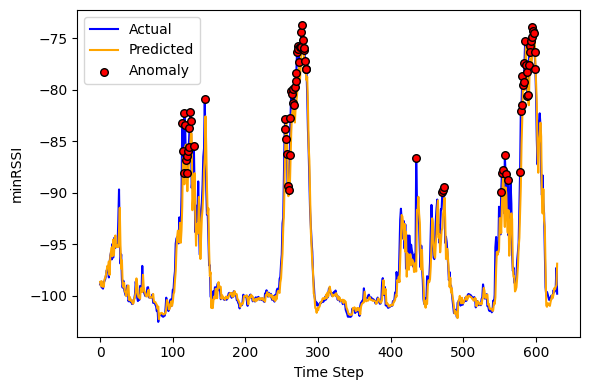

In [ ]:
sel_cell = top_3_cells.iloc[1]['cell']
plot_predictions(f'test_preds_{model_name}.csv', sel_cell, 1)

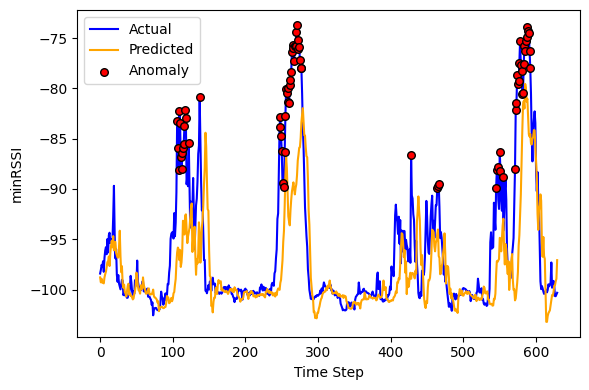

In [11]:
plot_predictions(f'test_preds_{model_name}.csv', sel_cell, 8)

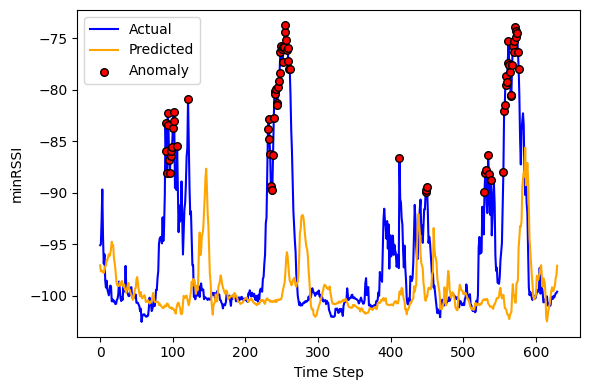

In [12]:
plot_predictions(f'test_preds_{model_name}.csv', sel_cell, 24)